# Imports

In [4]:
%matplotlib inline
from numpy import *

# Simulation code

In [14]:
def init_config(N,strategy):
    """Initializes a configurations.
    
    strategy -  one of random / all-up / all-down
    """
    if strategy == "random":
        return 2*random.randint(0,2,N)-1
    elif strategy == "all-up":
        return ones((N,),dtype=int)
    elif strategy == "all-down":
        return -1*ones((N,),dtype=int)
    else:
        raise ValueError("Unknown strategy in init_config")

In [142]:
ASSERT_EPS = 1.0e-7

class IsingModelMC_1D(object):
    "Implementation of a Metropolis Monte Carlo simulation of the 1d Ising model"
    
    def __init__(self,pars):
        """
        Constructor - initializes simulation
        
        pars - dictionary that contains parameters of the simulation. The following keys
               are required:
               -) system_size (int > 0)
               -) init_strategy (random / all-up / all-down)
               -) boundary_conditions (free / pbc)
               -) h_over_j (float)
               -) T (float > 0)
        """
        # PARAMETERS
        self.N = int(pars["system_size"])
        if self.N <= 0:
            raise ValueError("system_size must be larger than 0")
        
        if pars["boundary_conditions"] == "pbc":
            self.pbc = True
        elif pars["boundary_conditions"] == "free":
            self.pbc = False
        else:
            raise ValueError("Unknown boundary conditions")
        
        self.h_over_j = pars["h_over_j"]
        self.T = float(pars["T"])        
        if self.T <= 0.0:
            raise ValueError("T must be larger than 0")
        self.beta = 1.0/pars["T"]
        
        # SIMULATION VARIABLES
        self.config = init_config(self.N,pars["init_strategy"])
        
        # STATISTICAL VARIABLES
        self.reset_statistics_variables()
            
    def reset_statistics_variables(self):
        "Refreshes the values of all variables that are cumulatively updated while the simulation runs"
        self.n_attempted = 0
        self.n_accepted = 0
        
        self.t_timeseries = []
        
        self.E = self.get_E()
        self.E_sum = 0.0
        self.E_sum_samples = 0
        self.E_timeseries = []
        
        self.m = self.get_m()
        self.m_sum = 0.0
        self.m_sum_samples = 0.0
        self.m_timeseries = []
        self.m_increment = 2.0/self.N
        
    def __str__(self):
        "Returns a string that contains the current simulation state"
        s = "****************************************************************"
        s += "\n** Ising model MC simulation"
        s += "\n- % 10s = %i"%("N",self.N)
        s += "\n- % 10s = %s"%("PBC","YES" if self.pbc else "NO")
        s += "\n- % 10s = %.2f"%("h_over_j",self.h_over_j)
        s += "\n- % 10s = %.2f"%("E",self.E)
        s += "\n- % 10s = %.2f"%("T",self.T)
        s += "\n- % 10s = %.2f"%("beta",self.beta)
        s += "\n-- STATISTICS --------------------------------------------------"
        s += "\n- % 10s = %.2f"%("E",self.E)
        s += "\n- % 10s = %.2f"%("m",self.m)
        s += "\n- % 10s = %i"%("n_attempted",self.n_attempted)
        s += "\n- % 10s = %i"%("n_accepted",self.n_accepted)
        s += "\n- % 10s = %.2f"%("acc_ratio",float(self.n_accepted)/float(self.n_attempted) if self.n_attempted > 0 else 0.0)
        s += "\n- CONFIG:"
        s += "\n//%s//"%self.config_to_s()
        s += "\n****************************************************************"
        return s
        
    def config_to_s(self):
        "Returns a string that represents the current configuration"
        s = "%s"%('+' if self.config[0] == 1 else '-')
        for i in range(1,self.N):
            s += (" +" if self.config[i] == 1 else " -")
        return s
    
    def reset_cumulative_variables(self):
        "Update all variables that are cumulatively tracked while the simulation is running"
        self.m = self.get_m()
        self.E = self.get_E()

    def print(self):
        "Print the current simulation state"
        print(str(self))

    def get_E_single(self,i):
        """Return the contribution of spin i to the total energy
        
        Pairwise energies are split evenly between the two particles involved"""
        nbs = self.get_neighbors(i)
        sum_E = 0.0
        me = self.config[i]
        for j in nbs:
            sum_E += -0.5*me*self.config[j]
        sum_E += -self.h_over_j*me
        return sum_E
    
    def get_m(self):
        "Return the current magnetization"
        sum_m = 0
        for i in range(self.N):
            sum_m += self.config[i]
        return sum_m/self.N
        
    def do_sweep(self,debug_level=0):
        "Perform one simulation sweep that consists of (number of particles) MC moves"
        for i in range(self.N):
            if debug_level >= 2:
                print("* Doing move % 5i / % 5i"%(i+1,self.N))
            self.do_move(debug_level=debug_level)
            
    def accept_move(self,i,dE,debug_level=0):
        """Accept a flip of spin i
        
        If debug_level >= 3 or higher a consistency check of the cumulative variables E
        and m is performed. If debug_level >= 4 the state of the system before the move 
        is accepted is printed.
        """
        if debug_level >= 4:
            self.print()
        self.n_accepted += 1
        self.m -= self.m_increment*self.config[i]
        self.config[i] *= -1
        self.E += dE
        if debug_level >= 3:
            assert fabs(self.m - self.get_m()) < ASSERT_EPS, "inconsistent magnetization: running m = %.8f != %.8f = summed m"%(self.m,self.get_m())
            assert fabs(self.E - self.get_E()) < ASSERT_EPS, "inconsistent energy: running E = %.8f != %.8f = summed E"%(self.E,self.get_E())

        
    def do_stats(self,i,debug_level=0):
        "Update the statistics based on the current state of the system"
        self.t_timeseries.append(i)
        
        self.E_sum += self.E
        self.E_sum_samples += 1
        self.E_timeseries.append(self.E)
        
        # There used to be a bug here (extra division by N). m_sum is the
        # sum over all observations, so for the actual average, you have
        # to divide by the number of observations later.
        self.m_sum += self.m    
        self.m_sum_samples += 1
        self.m_timeseries.append(self.m)
        
    def print_stats_header(self):
        "Print a header line for the statistics output"
        s = "% 10s"%"t"
        s += " | % 10s"%"MAGN"
        s += " | % 10s"%"AVG MAGN"
        s += " | % 10s"%"ENERGY"
        s += " | % 10s"%"AVG ENERGY"
        s += " | % 10s"%"ACC RATIO"
        print(s)
        
    def print_stats(self,i):
        "Print the statistics output"
        s = "% 10s"%("% 8i"%i) # timestep
        
        s += " | % 10s"%("% 8.2f"%self.m)
        avg_m = self.m_sum / self.m_sum_samples if self.m_sum_samples > 0 else 0.0
        s += " | % 10s"%("% 8.2f"%avg_m)
        
        s += " | % 10s"%("% 8.2f"%self.E)
        avg_E = self.E_sum / self.E_sum_samples if self.E_sum_samples > 0 else 0.0
        s += " | % 10s"%("% 8.2f"%avg_E)
        
        acc_ratio = float(self.n_accepted)/float(self.n_attempted) if self.n_attempted > 0 else 0.0
        s += " | % 10s"%("% 8.2f"%acc_ratio)
        print(s)
        
    def run(self,n_sweeps,pars,debug_level=0):
        """Run a simulation
        
        n_sweeps - int: Number of sweeps to be performed
        pars - dict: parameters used for the simulation. Must include keys i_stats and i_stats_out
        debug_level - int: 0 or larger, controls level of debug output
        
        """
        i_stats = int(pars["i_stats"])
        i_stats_out = int(pars["i_stats_out"]) if i_stats > 0 else 0
        if i_stats_out > 0: 
            self.print_stats_header()
        for i in range(n_sweeps):
            self.do_move(debug_level=debug_level)
            if i_stats > 0 and (i % i_stats == 0):
                self.do_stats(i)
            if i_stats_out > 0 and (i % i_stats_out == 0):
                self.print_stats(i)
            if i % 10000 == 0:
                self.reset_cumulative_variables()
                
    def get_timeseries(self):
        """Return timeseries tracked while the last simulation was run
        
        Returns a dictionary with the name of variable as key and numpy.ndarray as values
        """
        return dict(
            t = array(self.t_timeseries),
            m = array(self.m_timeseries),
            E = array(self.E_timeseries)
        )
    
    ##########################################################################################################
    ## METHODS TO IMPLEMENT                                                                                 ##
    ##########################################################################################################    
            
    def get_neighbors(self,i):
        "Return the neighbors of spin i as an iterable (list or tuple)"
        ## -- START IMPLEMENTING HERE

        if i < 0 or i > self.N -1:
            raise ValueError("index outside of bounds.")

        index = i
        
        neighbors = array([index-1,index+1])
        check_pbc = self.pbc | ((neighbors >= 0) & (neighbors < self.N))

        return (neighbors[check_pbc] % self.N).tolist()


        ## -- STOP IMPLEMENTING HERE
        return neighbors
    
    def get_E(self):
        "Return the total current total energy of the system"
        E = 0.0
        ## -- START IMPLEMENTING HERE
        # Calculate total potential energy of the system
        # Use the get_neighbors function you implemented above and self.get_E_single
        for i in range(self.N):
            E += self.get_E_single(i)
        
        ## -- STOP IMPLEMENTING HERE
        
        return E
    
    def get_dE_single(self,i):
        "Return the change in energy of particle i is flipped"
        dE = 0.0
        ## -- START IMPLEMENTING HERE
        # Calculate the change in potential energy if spin i were to be flipped
        # Use the get_neighbors function you implemented above

        neighbors = self.get_neighbors(i)

        current_spin = self.config[i]
        new_spin = -1*current_spin
        spin_change = new_spin - current_spin

        # pair spin change
        for neighbor in neighbors:
            dE -= spin_change * self.config[neighbor]

        # Magnetic field spin change
        dE += -self.h_over_j * spin_change
        
        ## -- STOP IMPLEMENTING HERE
        return dE
    
    def acceptance(self,dE,debug_level=0):
        "Return true if Metropolis MC acceptance criterion is accepted - false otherwise"
        ## -- START IMPLEMENTING HERE
        # Implement the Metropolis acceptance criterion. dE is the difference in potential energy
        
        if dE <= 0 or random.rand() < exp(-dE*(self.T+1e-12)**(-1)):
            return True
        else:
            return False

        ## -- STOP IMPLEMENTING HERE
    
    def do_move(self,debug_level=0):
        "Perform a single Metropolis MC move including an acceptance test"
        accept = False
        ## -- START IMPLEMENTING HERE
        #i = random.randint(0,self.N)
        
        i = int(random.rand()*self.N)

        dE = self.get_dE_single(i)

        accept = self.acceptance(dE, debug_level=debug_level)
        ## -- STOP IMPLEMENTING HERE
        
        self.n_attempted += 1
        if accept:
            self.accept_move(i,dE,debug_level=debug_level)
        else:
            pass

In [170]:
## Optimization testing


from time import time

start = time()
for i in range(10000):
    # a = random.rand() < 0

    # if random.rand() < 0:
    #     a = True
    #a = random.choice(1000)
    #a = int(random.rand()*1000)
    a = random.randint(0,1000)
    #print(a, end=" )
end = time()

print(end-start)

0.02387547492980957


# Initialization

In [144]:
pars = dict(
    system_size = 1000,
    h_over_j = 0.0,
    init_strategy = "all-up",
    boundary_conditions = "pbc",
    T=2.1,
    i_stats = 10,
    i_stats_out = 10000
)

system = IsingModelMC_1D(pars)
system.print()

****************************************************************
** Ising model MC simulation
-          N = 1000
-        PBC = YES
-   h_over_j = 0.00
-          E = -1000.00
-          T = 2.10
-       beta = 0.48
-- STATISTICS --------------------------------------------------
-          E = -1000.00
-          m = 1.00
- n_attempted = 0
- n_accepted = 0
-  acc_ratio = 0.00
- CONFIG:
//+ + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + +

# Run

In [145]:
system.run(100000,pars,debug_level=0)
system.print()

         t |       MAGN |   AVG MAGN |     ENERGY | AVG ENERGY |  ACC RATIO
         0 |       1.00 |       1.00 |   -1000.00 |   -1000.00 |       0.00
     10000 |       0.01 |       0.25 |    -460.00 |    -493.51 |       0.51
     20000 |      -0.07 |       0.11 |    -472.00 |    -463.39 |       0.54
     30000 |      -0.06 |       0.06 |    -436.00 |    -452.76 |       0.54
     40000 |       0.02 |       0.04 |    -472.00 |    -451.29 |       0.55
     50000 |      -0.03 |       0.03 |    -464.00 |    -451.29 |       0.55
     60000 |       0.02 |       0.02 |    -484.00 |    -449.58 |       0.55
     70000 |       0.04 |       0.02 |    -400.00 |    -445.76 |       0.55
     80000 |       0.03 |       0.02 |    -424.00 |    -447.11 |       0.55
     90000 |      -0.03 |       0.02 |    -424.00 |    -445.77 |       0.55
****************************************************************
** Ising model MC simulation
-          N = 1000
-        PBC = YES
-   h_over_j = 0.00
-          

## 10 Correlation functions

Autocorrelation function

$$
C_m(k) = \frac{\langle m(t)m(t+k)\rangle - \langle m(t)\rangle\langle m(t+k) \rangle}{\langle m^2\rangle - \langle m \rangle ^2}
$$

In [274]:
import matplotlib.pyplot as plt

pars = dict(
    system_size = 100,
    h_over_j = 0.0,
    init_strategy = "random",
    boundary_conditions = "pbc",
    T=1.2,
    i_stats = 1,
    i_stats_out = 1
)

system = IsingModelMC_1D(pars)
system.print()

****************************************************************
** Ising model MC simulation
-          N = 100
-        PBC = YES
-   h_over_j = 0.00
-          E = -8.00
-          T = 1.20
-       beta = 0.83
-- STATISTICS --------------------------------------------------
-          E = -8.00
-          m = -0.08
- n_attempted = 0
- n_accepted = 0
-  acc_ratio = 0.00
- CONFIG:
//- + - - + - - + + + - + - - + + + - + - - - - - - - - - - + - - - - + + + + - - + + + + - + + + - + - - - - + + - - + + - - + + - + - - - - + - + + - + + + - - + + - - - - + - - + - - + + + + - + + -//
****************************************************************


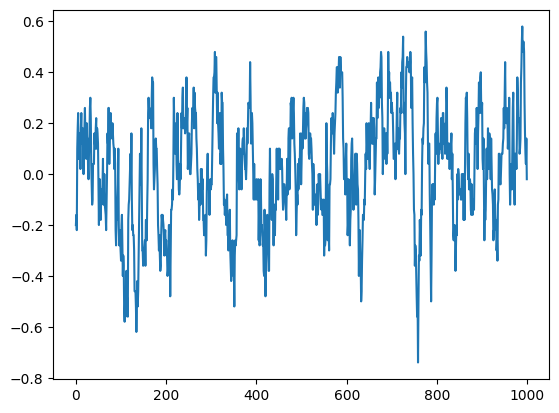

In [279]:
steps = 1000

magnetization = empty(steps)

for step in range(steps):
    system.do_sweep()
    magnetization[step] = system.get_m()

plt.plot(arange(steps), magnetization)
plt.show()

In [265]:
def compute_autocorrelation_old(steps, magnetization):
    autocorr = empty(steps)
    for k in range(steps):
        m_avg = mean(magnetization[:-k])
        m_k_avg = mean(magnetization[k:])
        corr = 0.0
        for i in range(steps-k):
            corr +=  magnetization[i]*magnetization[i+k]
        corr /= (steps-k)
        autocorr[k] = corr - m_avg * m_k_avg
    return autocorr

In [266]:
def compute_autocorrelation(m): #chatGPT
    m = asarray(m, dtype=float)
    N = m.size

    # mean and variance (population var)
    mu = m.mean()
    var = m.var()

    # demeaned series
    x = m - mu

    # full autocovariance via FFT-based correlate (faster for large N)
    # 'full' delivers lags from -(N-1) to +(N-1)
    acov_full = correlate(x, x, mode='full') / N

    # take only non-negative lags (from 0 to N-1)
    acov = acov_full[N-1:]

    # normalize by variance to get autocorrelation
    return acov / var

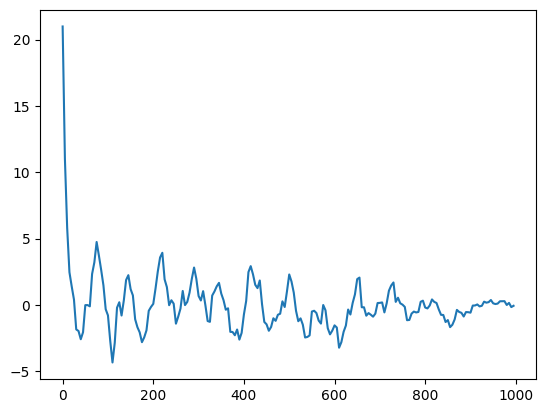

In [280]:
skip = 5


magnetization_variance = var(magnetization[::skip])


normalized_autocorrelation_function = compute_autocorrelation(magnetization[::skip]) / magnetization_variance

plt.plot(arange(steps)[::skip], normalized_autocorrelation_function)
plt.show()

In [150]:
def spin_correlation_analytical(r, T, h_over_j):
    '''
    calculate spin correlation of 0 and r (instead of i and j)
    '''
    beta = 1.0 / T
    h = h_over_j

    # gap in eigenvalues of the transfer matrix
    Delta = sqrt(exp(-2*beta) + exp(2*beta)*(sinh(beta*h))**2)
    lam1 = exp(beta)*cosh(beta*h) + Delta
    lam2 = exp(beta)*cosh(beta*h) - Delta

    # spontaneous magnetization
    m = sinh(beta*h) / sqrt(sinh(beta*h)**2 + exp(-4*beta))

    # full two-point function
    return m**2 + (1 - m**2) * (lam2/lam1)**r

In [151]:
def spin_correlation_numerical(system, steps, r):

    if (r >= system.N).any() or (r < 0).any():
        raise ValueError("Index out of bounds.")

    spin_correlation = empty((steps,len(r)))
    for i in range(steps):
        for j in range(len(r)):
            spin_correlation[i,j] = system.config[0] * system.config[r[j]]
            system.do_sweep()
    return mean(spin_correlation, axis = 0), std(spin_correlation, axis = 0, ddof = 1)/system.N**2

spin_correlation_numerical(system, 200, array([1,5]))

(array([1.  , 0.95]), array([0.00000000e+00, 3.13033464e-05]))

In [152]:
T_numerical = array([1e-12,0.5,0.7,1,1.5,2,2.3,2.7])
T_analytical = arange(1e-12,3,1e-2)
r = array([1,2,10,100,250])

In [153]:
numerical_spins = empty((len(T_numerical), len(r)))
numerical_spins_errors = empty((len(T_numerical), len(r)))
for i in range(len(T_numerical)):
    pars = dict(
        system_size = 500,
        h_over_j = 0.0,
        init_strategy = "all-up",
        boundary_conditions = "pbc",
        T=T_numerical[i], # implement the varying temperatures
        i_stats = 10,
        i_stats_out = 10000
    )

    system = IsingModelMC_1D(pars) # initiate the system
    system.run(10000,pars) # Equilibrate the system
    numerical_spins[i], numerical_spins_errors[i] = spin_correlation_numerical(system, 1000, r) # calculate spin correlation

save("numericalspins", [numerical_spins, numerical_spins_errors])

         t |       MAGN |   AVG MAGN |     ENERGY | AVG ENERGY |  ACC RATIO
         0 |       1.00 |       1.00 |    -500.00 |    -500.00 |       0.00
         t |       MAGN |   AVG MAGN |     ENERGY | AVG ENERGY |  ACC RATIO
         0 |       1.00 |       1.00 |    -500.00 |    -500.00 |       0.00
         t |       MAGN |   AVG MAGN |     ENERGY | AVG ENERGY |  ACC RATIO
         0 |       1.00 |       1.00 |    -500.00 |    -500.00 |       0.00
         t |       MAGN |   AVG MAGN |     ENERGY | AVG ENERGY |  ACC RATIO
         0 |       1.00 |       1.00 |    -500.00 |    -500.00 |       0.00
         t |       MAGN |   AVG MAGN |     ENERGY | AVG ENERGY |  ACC RATIO
         0 |       1.00 |       1.00 |    -500.00 |    -500.00 |       0.00
         t |       MAGN |   AVG MAGN |     ENERGY | AVG ENERGY |  ACC RATIO
         0 |       1.00 |       1.00 |    -500.00 |    -500.00 |       0.00
         t |       MAGN |   AVG MAGN |     ENERGY | AVG ENERGY |  ACC RATIO
         0 |

In [154]:
import matplotlib.pyplot as plt

/tmp/ipykernel_1780/2283115375.py:9: RuntimeWarning: overflow encountered in exp
  Delta = sqrt(exp(-2*beta) + exp(2*beta)*(sinh(beta*h))**2)
/tmp/ipykernel_1780/2283115375.py:9: RuntimeWarning: invalid value encountered in multiply
  Delta = sqrt(exp(-2*beta) + exp(2*beta)*(sinh(beta*h))**2)
/tmp/ipykernel_1780/2283115375.py:10: RuntimeWarning: overflow encountered in exp
  lam1 = exp(beta)*cosh(beta*h) + Delta
/tmp/ipykernel_1780/2283115375.py:11: RuntimeWarning: overflow encountered in exp
  lam2 = exp(beta)*cosh(beta*h) - Delta
/tmp/ipykernel_1780/2283115375.py:14: RuntimeWarning: invalid value encountered in divide
  m = sinh(beta*h) / sqrt(sinh(beta*h)**2 + exp(-4*beta))


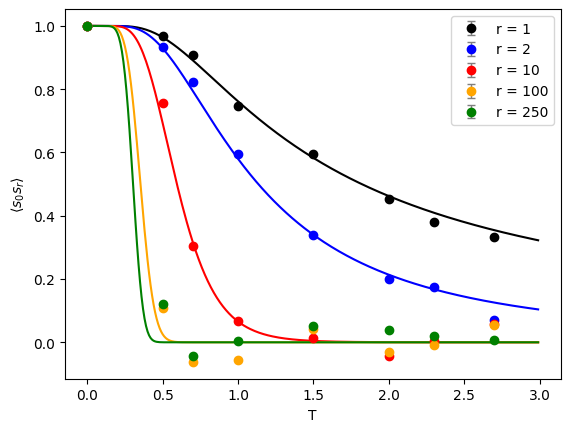

In [241]:
colors = ['black', 'blue', 'red', 'orange', 'green']

x = T_numerical
y, y_err = load("numericalspins.npy")

for i in range(len(r)):
    # plt.scatter(T_numerical, numerical_spins[:,i], label = f"r = {r[i]}", color = colors[i])
    plt.plot(T_analytical, spin_correlation_analytical(r[i], T_analytical, 0), color = colors[i])

    plt.errorbar(
    x, y[:,i],
    yerr=y_err[:,i]/system.N,
    fmt='o',           # circle markers
    ecolor='tab:gray', # errorbar color
    elinewidth=1,      # errorbar line width
    capsize=3,         # caps on the errorbars
    label = f"r = {r[i]}", 
    color = colors[i],
    )

plt.legend()
plt.xlabel("T")
plt.ylabel(rf"$\langle s_0 s_r \rangle$")
plt.show()